In [1]:
%load_ext autoreload
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, Grayscale
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit

%autoreload 2
from networks import *
from utils import *
from losses import *
from datasets import *

import matplotlib.pyplot as plt
import progressbar
import random

In [2]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)


# Set training static parameters and hyperparameters
nepochs=50
dims_latent = 16                            
learning_rate=1e-3
batch_size=32                                        
device=set_device("cuda", 1)
train_transform = Compose([
    Resize(28),
    ToTensor(),
])
train_size=0.001


Cuda installed but only 1 GPU(s) available! Running on GPU 0 GeForce GTX 1650!


# MNIST Example

In [3]:
# Datasets and dataloaders
ds = MNIST("./", download=False, train=True, transform=train_transform)
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=1-train_size, random_state=42).split(ds.data, ds.targets)
train_idx, valid_idx = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

X_train, y_train = ds.data[train_idx] / 255., ds.targets[train_idx]
trainds = TransformTensorDataset(X_train.unsqueeze(1).float(), y_train.float(), transform=train_transform)

idx_5 = []
for i in range(len(ds)):
    if ds[i][1] == 5:
        idx_5.append(i)
        if len(idx_5) == 1:
            break
trainds = Subset(ds, idx_5)

train_loader = DataLoader(trainds, batch_size=batch_size, shuffle=True, num_workers=4)


X = trainds[0][0].unsqueeze(0).to(device) # a sample for check ups
print("Trainable Images:", len(trainds))
print(X.shape, X.min().item(), X.max().item())

Trainable Images: 1
torch.Size([1, 1, 28, 28]) 0.0 1.0


## Autoencoder

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...


N/A% (0 of 50) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

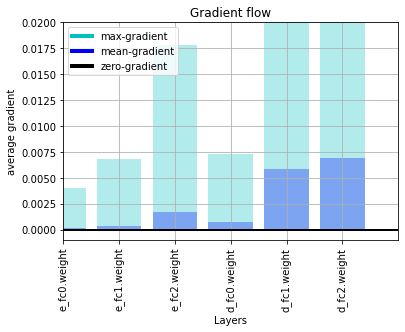


 {'epoch': 0, 'train_mse:': 0.22424916923046112, 'train_l2_loss': 0.22424916923046112}


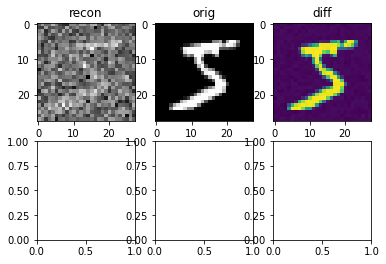

 20% (10 of 50) |####                    | Elapsed Time: 0:00:42 ETA:   0:02:21

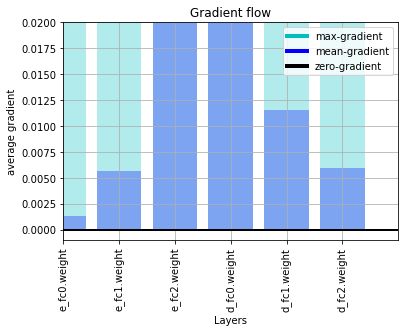


 {'epoch': 10, 'train_mse:': 0.0042296904139220715, 'train_l2_loss': 0.0042296904139220715}


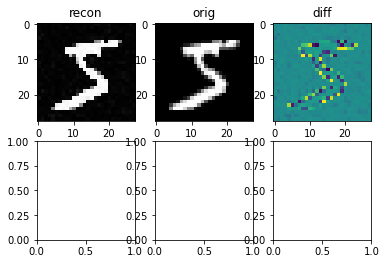

 40% (20 of 50) |#########               | Elapsed Time: 0:01:16 ETA:   0:01:38

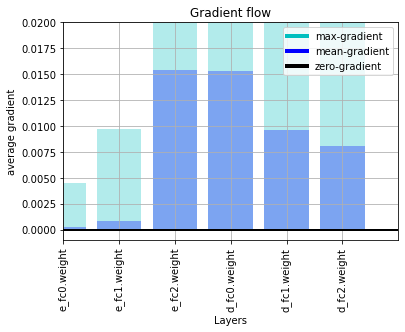


 {'epoch': 20, 'train_mse:': 0.0023613967932760715, 'train_l2_loss': 0.0023613967932760715}


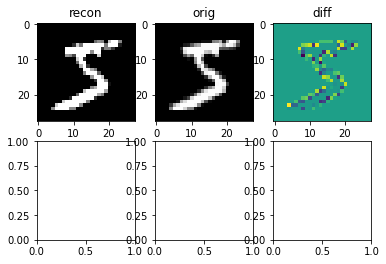

 60% (30 of 50) |##############          | Elapsed Time: 0:01:49 ETA:   0:01:02

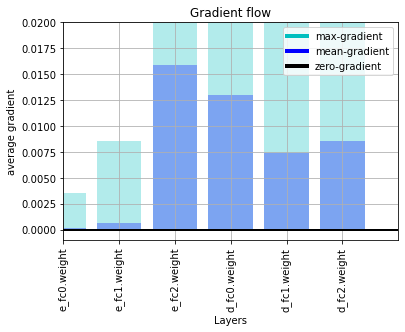


 {'epoch': 30, 'train_mse:': 0.0017644898034632206, 'train_l2_loss': 0.0017644898034632206}


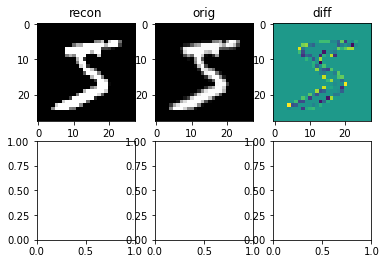

 80% (40 of 50) |###################     | Elapsed Time: 0:02:22 ETA:   0:00:34

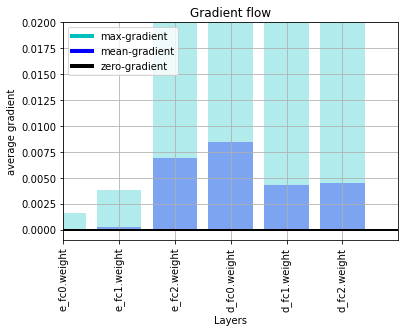


 {'epoch': 40, 'train_mse:': 0.0013196375221014023, 'train_l2_loss': 0.0013196375221014023}


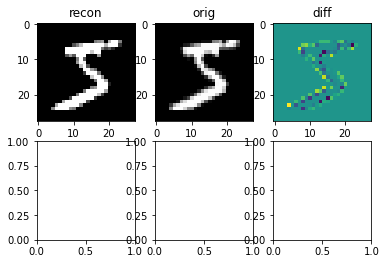

 98% (49 of 50) |####################### | Elapsed Time: 0:02:52 ETA:   0:00:03

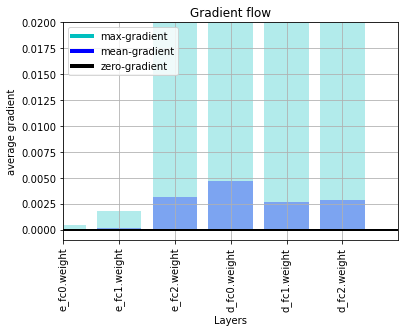


 {'epoch': 49, 'train_mse:': 0.0011019917437806726, 'train_l2_loss': 0.0011019917437806726}


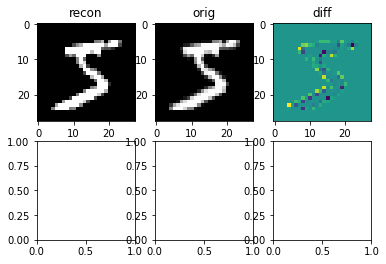

100% (50 of 50) |########################| Elapsed Time: 0:02:53 Time:  0:02:53


In [5]:
%autoreload 2
from networks import *

# Model and optimisers
model = Autoencoder(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X).shape)

# Losses
l2loss = nn.MSELoss(reduction="sum")

# Training loop
print("\n\nTraining started ...")
with progressbar.ProgressBar(max_value=nepochs) as bar:    
    for epoch in range(nepochs):
        epoch_loss = train_ae(model, train_loader, optimizer, l2loss, device=device)
        epoch_mse = validate_ae(model, train_loader, nn.MSELoss(reduction="mean"), device=device)
        bar.update(epoch)
        
        # Metric logs and plots
        log = {"epoch": epoch, "train_mse:": epoch_mse.item(), "train_l2_loss":epoch_mse.item()}
        if epoch % 10 == 0 or epoch==nepochs-1:
            # idx = random.randint(0, len(trainds))
            idx = -1
            X = trainds[idx][0].unsqueeze(0).to(device)
            recon = model(X)
            
            plot_grad_flow(model.named_parameters())
            print("\n", log)
            fig, axs = plt.subplots(2,3)
            axs[0, 0].imshow(recon[0, 0].cpu().detach().numpy(), cmap="gray")
            axs[0, 0].set_title("recon")

            axs[0, 1].imshow(X[0, 0].cpu().detach().numpy(), cmap="gray")
            axs[0, 1].set_title("orig")

            axs[0, 2].imshow(X[0, 0].cpu().detach().numpy() - recon[0, 0].cpu().detach().numpy())
            axs[0, 2].set_title("diff")

            plt.show()

## Variational Autoencoder

In [9]:
# Model and optimisers
model = ConvVAE(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X)[0].shape)

# Losses
l2loss = nn.MSELoss(reduction="sum")

# Training loop
print("\n\nTraining started ...")
with progressbar.ProgressBar(max_value=nepochs) as bar:    
    for epoch in range(nepochs):
        epoch_loss, _, epoch_kl = train_vae(model, train_loader, optimizer, l2loss, device=device)
        bar.update(epoch)

        # Metric logs and plots
        log = {"epoch": epoch, "train_loss":epoch_loss.item(), "train_kl_loss": epoch_kl.item()}
        if epoch % 10 == 0 or epoch==nepochs-1:
            # idx = random.randint(0, len(trainds))
            idx = -1
            X = trainds[idx][0].unsqueeze(0).to(device)
            recon, _, _ = model(X)

            print("\n", log)
            fig, axs = plt.subplots(2,3)
            axs[0, 0].imshow(recon[0, 0].cpu().detach().numpy(), cmap="gray")
            axs[0, 0].set_title("recon")

            axs[0, 1].imshow(X[0, 0].cpu().detach().numpy(), cmap="gray")
            axs[0, 1].set_title("orig")

            axs[0, 2].imshow(X[0, 0].cpu().detach().numpy() - recon[0, 0].cpu().detach().numpy())
            axs[0, 2].set_title("diff")

            plt.show()


NameError: name 'ConvVAE' is not defined

# CIFAR10 Example

In [6]:
# Train Transforms
train_transform = Compose([
    Resize(28),
    Grayscale(),
    ToTensor(),
])

# Datasets and dataloaders
ds = CIFAR10("./", download=True, train=True, transform=train_transform)
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=1-train_size, random_state=42).split(ds.data, ds.targets)
train_idx, valid_idx = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

# X_train, y_train = ds.data[train_idx] / 255., ds.targets[train_idx]
# trainds = TensorDataset(X_train.unsqueeze(1).float(), y_train.float())

trainds = Subset(ds, [0])

idx_5 = []
for i in range(len(ds)):
    if ds[i][1] == 5:
        idx_5.append(i)
        if len(idx_5) == 1:
            break
trainds = Subset(ds, idx_5)

train_loader = DataLoader(trainds, batch_size=batch_size, shuffle=True, num_workers=4)

X = trainds[0][0].unsqueeze(0).to(device) # a sample for check ups
print("Trainable Images:", len(trainds))
print(X.shape, X.min().item(), X.max().item())


Files already downloaded and verified
Trainable Images: 1
torch.Size([1, 1, 28, 28]) 0.01568627543747425 0.6784313917160034


## Autoencoder

In [ ]:
%autoreload 2
from networks import *
# Model and optimisers
model = Autoencoder(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X).shape)

# Losses
l2loss = nn.MSELoss(reduction="sum")

# Training loop
print("\n\nTraining started ...")
with progressbar.ProgressBar(max_value=nepochs) as bar:    
    for epoch in range(nepochs):
        epoch_loss, _ = train_ae(model, train_loader, optimizer, l2loss, device=device)
        bar.update(epoch)
            
        # Metric logs and plots
        log = {"epoch": epoch, "train_l2_loss":epoch_loss.item()}
        if epoch % 10 == 0 or epoch==nepochs-1:
            # idx = random.randint(0, len(trainds))
            idx = -1
            X = trainds[idx][0].unsqueeze(0).to(device)
            recon = model(X)
            
            plot_grad_flow(model.named_parameters())
            print("\n", log)
            fig, axs = plt.subplots(2,3)
            axs[0, 0].imshow(recon[0, 0].cpu().detach().numpy(), cmap="gray")
            axs[0, 0].set_title("recon")

            axs[0, 1].imshow(X[0, 0].cpu().detach().numpy(), cmap="gray")
            axs[0, 1].set_title("orig")

            axs[0, 2].imshow(X[0, 0].cpu().detach().numpy() - recon[0, 0].cpu().detach().numpy())
            axs[0, 2].set_title("diff")

            plt.show()